# First Year Project - Project 3: Natural Language Processing
***
#### Group G: Christina Aftzidis, Germán Buttiero, Hubert Wójcik, Laurids Holme Pedersen, Paula Menshikoff
Submission: 03.07.2022
***

This notebook contains the process of training a classifier with (a) tweets containing hate speech and (b) tweets with stance on a certain topic, and classifying them into categories. 

The initial data was obtained from the [TweetEval](https://github.com/cardiffnlp/tweeteval) GitHub repository. 


### Introduction
***

### Running this notebook
*** 
Below the imports, there is a code cell that stores the variable 'savefigs'. If set to True, it automatically saves all of the plots into a separate file. If you do not want to save the plots, set 'savefigs' to False.

There are some imports that **require** the library to be installed in the environment that you are running the code in. These cells are above and under the imports. Please **uncomment** the ones that you do not have installed, otherwise the code will not run.

### Required libraries and further imports
***

In [ ]:
#!pip install datasets

In [1]:
#general imports
import numpy as np
import re 
import pandas as pd
import Config #stores all our file paths
import string 
import os 
from difflib import Differ #for comparing tokenizers
from datasets import load_dataset

#sklearn imports
from sklearn.metrics import confusion_matrix, balanced_accuracy_score 
from sklearn.model_selection import train_test_split

#imports for data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#nltk imports
from nltk.tokenize import TweetTokenizer

#importing our classifiers from our script
from classifiers import WithStopVectorClassifier, NoStopVectorClassifier, BagOfWordsClassifier, RandomForest, DecisionTree 

In [2]:
savefigs = True

if savefigs:
    if not os.path.isdir('../figs'):
        os.makedirs('../figs')

#### Imports that need to be installed in the environment the code is run in

In [3]:
#download the spacy pipeline pretrained on the english language
#!python -m spacy download en_core_web_lg

In [4]:
#download the list of stopwords
#!python -m nltk.downloader stopwords

### Loading the data

***


In [5]:
with open(Config.hate_train_text_path, 'r', encoding = 'utf-8') as infile:
    train_hate = [line.strip() for line in infile]

with open(Config.abortion_train_text_path, 'r', encoding = 'utf-8') as infile:
    train_abortion = [line.strip() for line in infile]

### Preprocessing

***

In this part, we compare TweetTokenizer given by NLTK with the tokenizer provided by our teacher, Christian Hardmeier.

In [ ]:
def custom_strip(text): 
    pattern = re.compile(r'\ #SemST \n')
    for i, line in enumerate(text):
        match = re.search(pattern, line)
        if match:
            line = line[0:match.start()]
        else:
            line = line.strip()
        text[i] = line
    return text

with open(Config.abortion_test_text_path, 'r+') as f:
    f = custom_strip(f)

In [6]:
#a tokeniser provided by Christian Hardmeier
def tokenise(line): 
    tokens = []
    unmatchable = []

    # Compile patterns for speedup
    token_pat = re.compile(r'\w+')
    skippable_pat = re.compile(r'\s+')  # typically spaces

    # As long as there's any material left...
    while line:
        # Try finding a skippable token delimiter first.
        skippable_match = re.search(skippable_pat, line)
        if skippable_match and skippable_match.start() == 0:
            # If there is one at the beginning of the line, just skip it.
            line = line[skippable_match.end():]
        else:
            # Else try finding a real token.
            token_match = re.search(token_pat, line)
            if token_match and token_match.start() == 0:
                # If there is one at the beginning of the line, tokenise it.
                tokens.append(line[:token_match.end()])
                line = line[token_match.end():]
            else:
                # Else there is unmatchable material here.
                # It ends where a skippable or token match starts, or at the end of the line.
                unmatchable_end = len(line)
                if skippable_match:
                    unmatchable_end = skippable_match.start()
                if token_match:
                    unmatchable_end = min(unmatchable_end, token_match.start())
                # Add it to unmatchable and discard from line.
                unmatchable.append(line[:unmatchable_end])
                line = line[unmatchable_end:]
    return tokens


#### Loading data using different tokenizers

In [7]:
tt = TweetTokenizer()
tweet_tokeniser = []
tokeniser = []
NUM = 20 #select the first 100 tweets

for line in train_hate[:NUM]:
    tweet_tokeniser += tt.tokenize(line)
    tokeniser += tokenise(line)

#### Printing the difference in tokenizing methods
Selecting the write tokenizer is vital for us, thus we thoroughly investigate the difference between the two tokenizers.

In [8]:
d = Differ()
difference = list(d.compare(tokeniser,tweet_tokeniser))
dif = set()
for word in difference:
    if word[0] in ('+', '-') and word not in dif:
        dif.add(word)
print(dif)

{'- m', "+ I'm", '+ 😡', '- And', '+ #Spain', '+ -', '+ ...', '+ tweeted.And', '+ #RefugeesNotWelcome', '- anti', '+ ,', '- I', '+ @user', '+ …', '+ !', "+ NGO's", "+ '", '+ .', '- RefugeesNotWelcome', '- tweeted', '- Spain', '+ anti-immigrant', '- YesAllMen', '+ :', '- NGO', '+ #YesAllMen', '- that', '+ ?', '+ ~', '+ 😂', '- immigrant', '+ 😎', '+ "', '- user', '- s', "+ that's"}


As we can see from the printed difference, the TweetTokenizer takes **emoticons**, **hashtags**, **mentions** (@user) into account and is generally more suited for the task of tokenizing tweets.

### Characterising the data

***


In [9]:
complete_hate = ' '.join(train_hate)
complete_abortion = ' '.join(train_abortion)

complete_hate = complete_hate.split()
complete_abortion = complete_abortion.split()

#### Corpus size

In [10]:
print(f'The corpus size for the hate train set is {len(complete_hate)}')
print(f'The corpus size for the abortion train set is {len(complete_abortion)}')

The corpus size for the hate train set is 187397
The corpus size for the abortion train set is 10231


#### Vocabulary size

In [11]:
print(f'The vocabulary size for the hate train set is {len(set(complete_hate))}')
print(f'The vocabulary size for the abortion train set is {len(set(complete_abortion))}')

The vocabulary size for the hate train set is 32745
The vocabulary size for the abortion train set is 3490


#### Type/Token Ratio

In [12]:
tw = TweetTokenizer(reduce_len = True, strip_handles = True)

tokens_hate = [tw.tokenize(word) for word in complete_hate]
tokens_abortion = [tw.tokenize(word) for word in complete_abortion]

type_hate = set([item for sublist in tokens_hate for item in sublist])
type_abortion = set([item for sublist in tokens_abortion for item in sublist])

print(f'The type to token ratio for the hate train set is {len(type_hate)/len(tokens_hate)}')
print(f'The type to token ratio for the abortion train set is {len(type_abortion)/len(tokens_abortion)}')

The type to token ratio for the hate train set is 0.12494863845205632
The type to token ratio for the abortion train set is 0.2902942038901378


This tells us that the hate train set is much larger overall but has a lower ratio of types to tokens, i.e. less unique words than the abortion train set.

#### Most frequent tokens

In [13]:
hate = []
for item in tokens_hate:
    hate += item
punct = []
for word in hate:
    if word not in string.punctuation:
        punct.append(word)
tokh, counth = np.unique(punct, return_counts=True) 
count_sorth = np.argsort(-counth)
print(f'The top ten most frequent tokens in the hate train set are {tokh[count_sorth][:10]}')

abortion = []
for item in tokens_abortion:
    abortion += item
puncta = []
for word in abortion:
    if word not in string.punctuation:
        puncta.append(word)
toka, counta = np.unique(puncta, return_counts=True) 
count_sorta = np.argsort(-counta)
print(f'The top ten most frequent tokens in the abortion train set are {toka[count_sorta][:10]}')

The top ten most frequent tokens in the hate train set are ['the' 'to' 'a' 'and' 'you' 'of' 'in' 'is' 'for' 'I']
The top ten most frequent tokens in the abortion train set are ['#SemST' 'to' 'the' 'a' 'is' 'of' 'for' 'you' 'that' 'I']


The '#SemST' is not an actual word. However, it is at the end of every tweet in our dataset. For training our classifier, we removed it. Here we did not.

#### Tokens that appear only once

In [14]:
count_up_h = np.argsort(counth)
ch = [item for item in counth if item ==1]
print(f'The tokens that only appear once in the hate train set are {tokh[count_up_h][:len(ch)]}. \
In total there are {len(tokh[count_up_h][:len(ch)])} amount of tokens that appear once.')

count_up_a = np.argsort(counta)
ca = [item for item in counta if item == 1]
print(f'The tokens that only appear once in the abortion train set are {toka[count_up_a][:len(ca)]}. \
In total there are {len(toka[count_up_a][:len(ca)])} amount of tokens that appear once.')

The tokens that only appear once in the hate train set are ['##NoMoreAfricans' 'cleavers' 'clenched' ... 'Hirono' 'MeP' 'Hatred']. In total there are 13730 amount of tokens that appear once.
The tokens that only appear once in the abortion train set are ['#15minutes' 'recognised' 'recognize' ... 'Cora' 'tiny' 'timely']. In total there are 1993 amount of tokens that appear once.


The hate dataset is a lot larger than the abortion dataset and that is also visible when comparing the amount of tokens that appear once, and the unique words overall. However, the list of most frequent words is almost the same. Therefore, we can conclude that the most frequent words do not depend on the subject of the tweets.

In [50]:
#set the font size to 14 for all of the plots
font = {'size'   : 14}

plt.rc('font', **font)

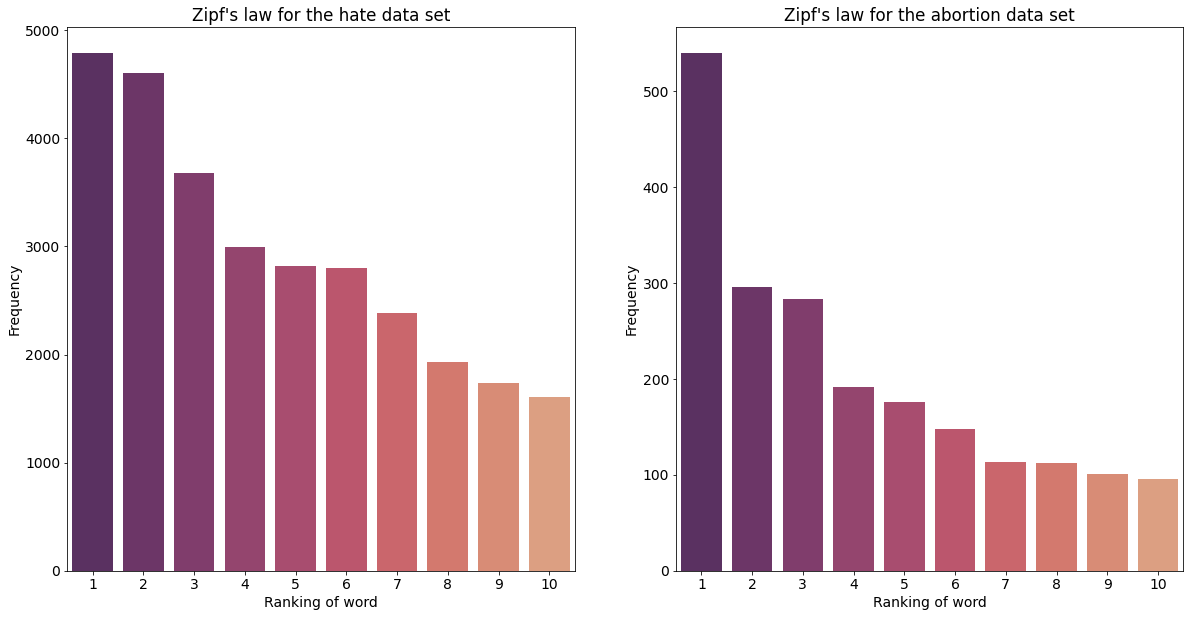

In [51]:
fig, axs = plt.subplots(1, 2, figsize = (20,10))

sns.barplot(x = [i for i in range(1, 11)], y = counth[count_sorth][:10], ax = axs[0], palette = 'flare_r');
sns.barplot(x = [i for i in range(1, 11)], y =counta[count_sorta][:10], ax = axs[1], palette = 'flare_r');

axs[0].set(xlabel = 'Ranking of word', ylabel = 'Frequency', title = 'Zipf\'s law for the hate data set');
axs[1].set(xlabel = 'Ranking of word', ylabel = 'Frequency', title = 'Zipf\'s law for the abortion data set');

if savefigs:
    plt.savefig('../figs/figure_zipf.png', bbox_inches= 'tight')

From these bar plots, it does not look like Zipf's law is true for our datasets.

### Manual annotation and Inter-Annotator Agreement

*** 


In [22]:
ratings = pd.read_csv('../dataset/Task3rating.csv')
ratings.drop(ratings.tail(1).index, inplace=True)

truth = ratings['Real labels']
Chris = ratings[['Chris', 'Real labels']]
German = ratings['Germán']
Hubert = ratings['Hubert']
Laurids = ratings['Laurids']
Paula = ratings['Paula']

In [23]:
def plot_cf(real, guess, name):
    #creating a confusion matrix from our guesses
    cf = confusion_matrix(real, guess)

    #creating labels to add to the heatmap
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    #creating the heatmap and adding titels
    f, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

    plt.suptitle('Heatmap of the confusion matrix', fontsize=18, x=0.45)
    plt.title(f'Heatmap for {name}', fontsize=12)

    if savefigs:
        plt.savefig(f'../figs/figure_{name}.png', bbox_inches='tight')

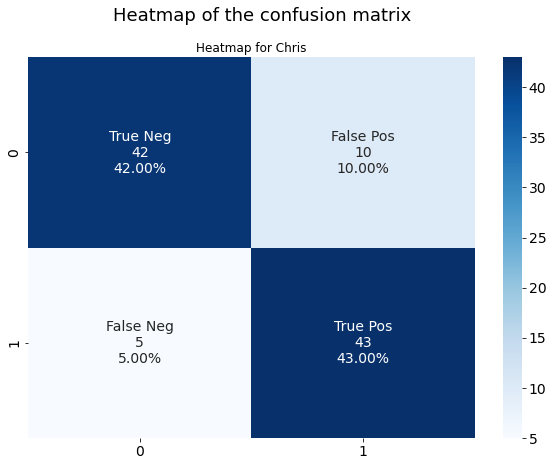

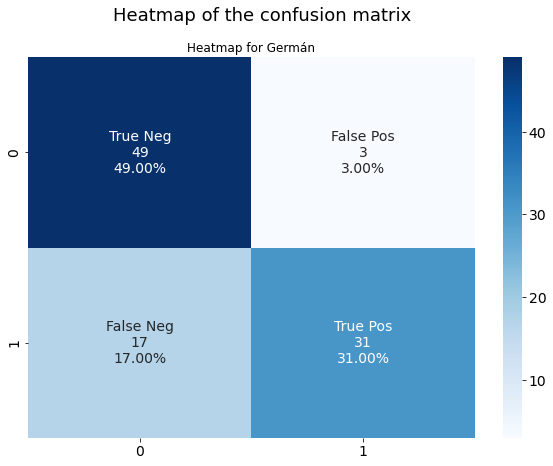

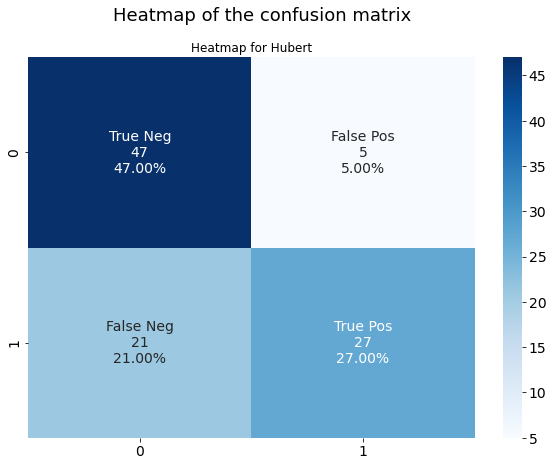

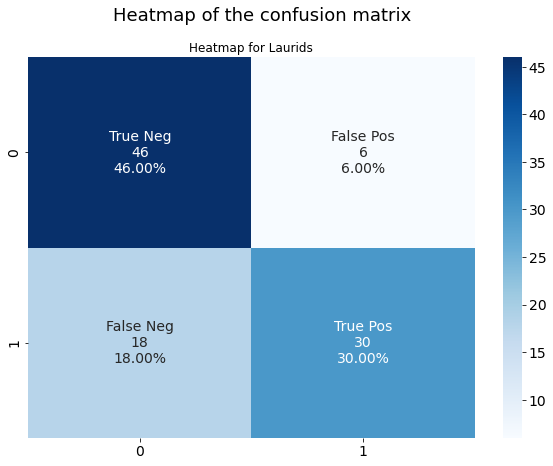

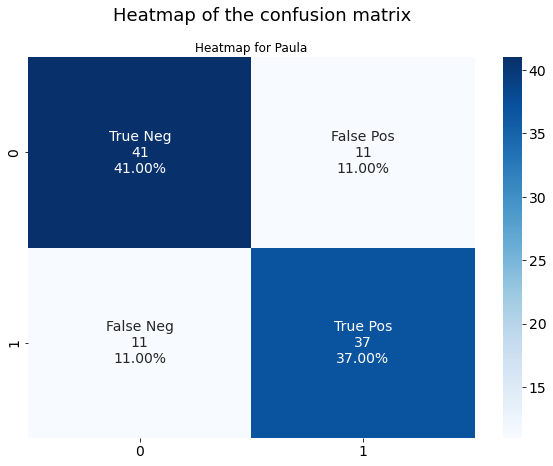

In [52]:
names = ['Chris', 'Germán', 'Hubert', 'Laurids', 'Paula']

for name in names:
    plot_cf(ratings['Real labels'], ratings[name], name)

In [25]:
for name in names:
    score = balanced_accuracy_score(ratings['Real labels'], ratings[name])
    print(f'{name} got a balanced accuracy score of {score:.2f}')

Chris got a balanced accuracy score of 0.85
Germán got a balanced accuracy score of 0.79
Hubert got a balanced accuracy score of 0.73
Laurids got a balanced accuracy score of 0.75
Paula got a balanced accuracy score of 0.78


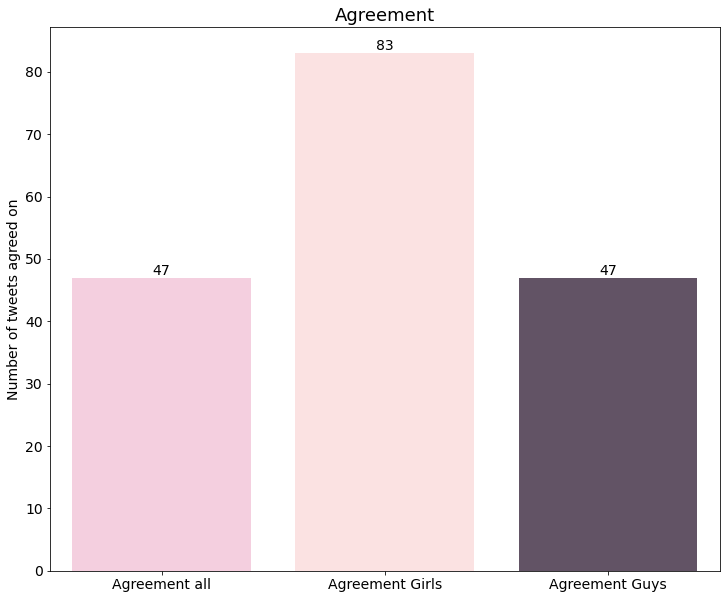

In [54]:
fig, ax = plt.subplots(figsize=(12,10))



dy = [sum(ratings['Agreement']), sum(ratings['Agreement girls']), sum(ratings['Agreement guys'])]
dx = ['Agreement all', 'Agreement Girls', 'Agreement Guys']

color_list = ['#fac9de', '#ffdede', '#645068']

sns.barplot(x = dx, y = dy, ax=ax,  palette=color_list);
plt.title('Agreement', fontsize = 18);
ax.set_ylabel('Number of tweets agreed on', fontsize = 14);
ax.bar_label(ax.containers[0], fontsize = 14);

if savefigs:
    plt.savefig('../figs/figure_agreement.png', bbox_inches='tight')

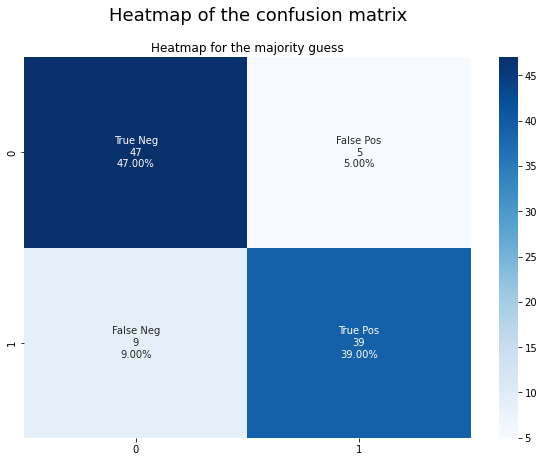

In [27]:
plot_cf(ratings['Real labels'], ratings['Majority Vote'], 'the majority guess')
if savefigs:
    plt.savefig('../figs/figure_all.png', bbox_inches = 'tight')

The results from this task show that different annotators had different perceptions of what hate speech is. Moreover, there seemed to be a difference in agreement when taking the gender of the annotators into account. However, this could also be due to an unequal number of annotators (2 and 3). Even though we have carefully read the guidelines, the difference in our results may be also caused by our internal beliefs that subconsciously may have impacted our annotations. \
After talking to each other, we realized that we interpreted tweets differently due to their context and our background knowledge. If we count the label the majority chose, then we can see that we overall have a 86% accuracy score. There is a higher amount of false negatives than false positives which could be attributed to the high amount of false negatives that Germán, Hubert, and Laurids got.

### Training a classifier

***

run the one with the highest accuracy on the validation set with the test set



In [28]:
vec_clf = WithStopVectorClassifier(Config.hate_train_text_path, Config.hate_train_labels_path)
vec_f1, vec_acc, vec_prec, vec_rec = vec_clf.getClassifierAccuracy(Config.hate_val_text_path, Config.hate_val_labels_path)

In [ ]:
vecs_clf = NoStopVectorClassifier(Config.hate_train_text_path, Config.hate_train_labels_path)
vecs_f1, vecs_acc, vecs_prec, vecs_rec = vecs_clf.getClassifierAccuracy(Config.hate_val_text_path, Config.hate_val_labels_path)

In [ ]:
bow_clf = BagOfWordsClassifier(Config.hate_train_text_path, Config.hate_train_labels_path)
bow_f1, bow_acc, bow_prec, bow_rec = bow_clf.getClassifierAccuracy(Config.hate_val_text_path, Config.hate_val_labels_path)

In [ ]:
rf_clf = RandomForest(Config.hate_train_text_path, Config.hate_train_labels_path)
rf_f1, rf_acc, rf_prec, rf_rec = rf_clf.getClassifierAccuracy(Config.hate_val_text_path, Config.hate_val_labels_path)

In [ ]:
dt_clf = DecisionTree(Config.hate_train_text_path, Config.hate_train_labels_path)
dt_f1, dt_acc, dt_prec, dt_rec = dt_clf.getClassifierAccuracy(Config.hate_val_text_path, Config.hate_val_labels_path)

In [ ]:
d = {
    'Name': ['Vector Classifier', 'Vector Classifier with stopword removal', 'Bag of Words ', 'Random Forest', 'Decision Tree'],
    'Accuracy': [vec_acc, vecs_acc, bow_acc, rf_acc, dt_acc],
    'Precision' : [vec_prec, vecs_prec, bow_prec, rf_prec, dt_prec],
    'Recall' : [vec_rec, vecs_rec, bow_rec, rf_rec, dt_rec],
    'F1-Score' : [vec_f1, vecs_f1, bow_f1, rf_f1, dt_f1]
}

df = pd.DataFrame(data= d)
df

,Name,Accuracy,Precision,Recall,F1-Score
0,Vector Classifier,0.711,0.707579,0.693517,0.696160
1,Vector Classifier with stopword removal,0.711,0.705201,0.697992,0.700058
2,Bag of Words,0.689,0.684518,0.687448,0.685120
3,Random Forest,0.750,0.744974,0.741273,0.742739
4,Decision Tree,0.684,0.678410,0.680399,0.679065


In [ ]:
ab_vec_clf = WithStopVectorClassifier(Config.abortion_train_text_path, Config.abortion_train_labels_path)
ab_vec_f1, ab_vec_acc, ab_vec_prec, ab_vec_rec = ab_vec_clf.getClassifierAccuracy(Config.abortion_val_text_path, Config.abortion_val_labels_path)

In [ ]:
ab_vecs_clf = NoStopVectorClassifier(Config.abortion_train_text_path, Config.abortion_train_labels_path)
ab_vecs_f1, ab_vecs_acc, ab_vecs_prec, ab_vecs_rec = ab_vecs_clf.getClassifierAccuracy(Config.abortion_val_text_path, Config.abortion_val_labels_path)

In [ ]:
ab_bow_clf = BagOfWordsClassifier(Config.abortion_train_text_path, Config.abortion_train_labels_path)
ab_bow_f1, ab_bow_acc, ab_bow_prec, ab_bow_rec = ab_bow_clf.getClassifierAccuracy(Config.abortion_val_text_path, Config.abortion_val_labels_path)

In [ ]:
ab_rf_clf = RandomForest(Config.abortion_train_text_path, Config.abortion_train_labels_path)
ab_rf_f1, ab_rf_acc, ab_rf_prec, ab_rf_rec = ab_rf_clf.getClassifierAccuracy(Config.abortion_val_text_path, Config.abortion_val_labels_path)

In [ ]:
ab_dt_clf = DecisionTree(Config.abortion_train_text_path, Config.abortion_train_labels_path)
ab_dt_f1, ab_dt_acc, ab_dt_prec, ab_dt_rec = ab_dt_clf.getClassifierAccuracy(Config.abortion_val_text_path, Config.abortion_val_labels_path)

In [ ]:
da = {
    'Name': ['Vector Classifier', 'Vector Classifier with stopword removal', 'Bag of Words ', 'Random Forest', 'Decision Tree'],
    'Accuracy': [ab_vec_acc, ab_vecs_acc, ab_bow_acc, ab_rf_acc, ab_dt_acc],
    'Precision' : [ab_vec_prec, ab_vecs_prec, ab_bow_prec, ab_rf_prec, ab_dt_prec],
    'Recall' : [ab_vec_rec, ab_vecs_rec, ab_bow_rec, ab_rf_rec, ab_dt_rec],
    'F1-Score' : [ab_vec_f1, ab_vecs_f1, ab_bow_f1, ab_rf_f1, ab_dt_f1]
}

dfa = pd.DataFrame(data= da)
dfa

,Name,Accuracy,Precision,Recall,F1-Score
0,Vector Classifier,0.712121,0.684781,0.620370,0.632763
1,Vector Classifier with stopword removal,0.757576,0.775424,0.685185,0.705836
2,Bag of Words,0.606061,0.605772,0.527778,0.550186
3,Random Forest,0.575758,0.679817,0.435185,0.442390
4,Decision Tree,0.666667,0.623782,0.601852,0.609181


Due to the results of the classifiers using our validation set, we decided to use the RandomForest for the hate data set and the Vector classifier with stopword removal for the abortion stance detection.

In [ ]:
hf1, hacc, hprec, hrec = vec_clf.getClassifierAccuracy(Config.hate_test_text_path, Config.hate_test_labels_path)
print(f'The RandomForest classifier gets an accuracy of {hacc} for the test set. The f1-score is {hf1}, the precision {hprec} and the recall {hrec}')

The RandomForest classifier gets an accuracy of 0.5575757575757576 for the test set. The f1-score is 0.5430234192037471, the precision 0.6329941788823059 and the recall 0.6003549152554981


In [ ]:
af1, aacc, aprec, arec = ab_vecs_clf.getClassifierAccuracy(Config.abortion_test_text_path, Config.abortion_test_labels_path)
print(f'The Vector classifier with stopword removal gets an accuracy of {aacc} for the test set. The f1-score is {af1}, the precision {aprec} and the recall {arec}')

The Vector classifier with stopword removal gets an accuracy of 0.6107142857142858 for the test set. The f1-score is 0.5309461157351172, the precision 0.5456800978063956 and the recall 0.5641055133808757


### Data Augmentation

***
For our external data we used the [tweets_hate_speech_detection](https://huggingface.co/datasets/tweets_hate_speech_detection/tree/main) dataset from huggingface. 

#### Loading the external data

In [33]:
dataset = load_dataset("tweets_hate_speech_detection")

Using custom data configuration default
Reusing dataset tweets_hate_speech_detection (C:\Users\chris\.cache\huggingface\datasets\tweets_hate_speech_detection\default\0.0.0\c6b6f41e91ac9113e1c032c5ecf7a49b4e1e9dc8699ded3c2d8425c9217568b2)
100%|██████████| 1/1 [00:00<?, ?it/s]


#### Classifying the external data

In [34]:
#selecting the train and labels from the dictionary and storing them in variables
train, labels = [], []

for i in range(len(dataset['train'])):
    train.append(dataset['train'][i]['tweet'])
    labels.append(dataset['train'][i]['label'])

#splitting the external data
train_x, temp_x, train_y, temp_y = train_test_split(train, labels, test_size=0.2, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size = 0.5, random_state=42)

#initializing the classifier, for the external data we chose WithoutStopVectorClassifier
vecf_clf = WithStopVectorClassifier(train_x, train_y, already=True)
hf1, hacc, hprec, hrec = vecf_clf.getClassifierAccuracy(val_x, val_y, already=True)
f1, acc, prec, rec = vecf_clf.getClassifierAccuracy(test_x, test_y, already=True)

31962


#### The results

In [35]:
print(f'accuracy: {acc}, f1: {f1}, precision: {prec}, recall: {rec}')

accuracy: 0.6735178510508907, f1: 0.734253541553944, precision: 0.892964635063958, recall: 0.6735178510508907


The accuracy is so high because it does not take into account that our data is not balanced. Non hatespeech tweets are more frequent than hatespeech tweets.

1. Non hatespeech: 29720
2. Hatespeech: 2242
